In [16]:
import os
os.environ["DISABLE_MPI"]="true"
from pixell import curvedsky, enmap
from scipy.signal import savgol_filter
from cmbsky import safe_mkdir, get_disable_mpi, ClBinner
from falafel import utils, qe
import healpy as hp
import yaml
import argparse
from orphics import maps, mpi
import numpy as np
import pickle
from string import Template
import sys
sys.path.append("../bin")
from run_auto import get_sims_from_cls,get_sim_model_from_data
import matplotlib.pyplot as plt

In [2]:
est_maps = "hilc_hilc-tszandcibd_hilc_hilc"
with open("../scripts/test_%s/data_cl_signal_dict.pkl"%est_maps,"rb") as f:
    data_cl_signal_dict = pickle.load(f)
with open("../scripts/test_%s/data_cl_noise_dict.pkl"%est_maps,"rb") as f:
    data_cl_noise_dict = pickle.load(f)
with open("../scripts/test_%s/total_Cl_from_data.pkl"%est_maps,"rb") as f:
    data_cltot_dict = pickle.load(f)

In [3]:
print(data_cl_signal_dict.keys())
print(data_cl_noise_dict.keys())
print(data_cltot_dict.keys())

dict_keys([('hilc', 'hilc'), ('hilc', 'hilc-tszandcibd'), ('hilc-tszandcibd', 'hilc'), ('hilc-tszandcibd', 'hilc-tszandcibd')])
dict_keys([('hilc', 'hilc'), ('hilc', 'hilc-tszandcibd'), ('hilc-tszandcibd', 'hilc'), ('hilc-tszandcibd', 'hilc-tszandcibd')])
dict_keys([('hilc-tszandcibd', 'hilc-tszandcibd'), ('hilc-tszandcibd', 'hilc'), ('hilc', 'hilc-tszandcibd'), ('hilc', 'hilc')])


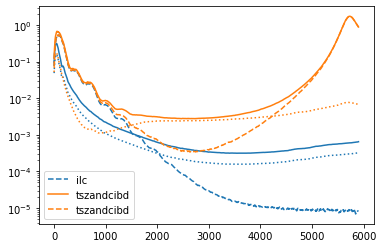

In [26]:
%matplotlib inline

fig,ax = plt.subplots()

ax.plot(data_cl_noise_dict['hilc', 'hilc'][100:]+data_cl_noise_dict['hilc', 'hilc'][100:], '-', color='C0')
ax.plot(data_cl_signal_dict['hilc','hilc'][100:], '--', color='C0', label='ilc')
ax.plot(data_cl_noise_dict['hilc', 'hilc'][100:], ':', color='C0')

#ax.plot(data_cl_signal_dict['hilc-tszandcibd', 'hilc'][100:], '-', color='C1', label='ilc x tszandcibd')
#ax.plot(data_cl_noise_dict['hilc-tszandcibd', 'hilc'][100:], ':', color='C1')
ax.plot(data_cl_signal_dict['hilc-tszandcibd', 'hilc-tszandcibd'][100:]+
        data_cl_noise_dict['hilc-tszandcibd', 'hilc-tszandcibd'][100:], 
        color='C1', label='tszandcibd')
ax.plot(data_cl_signal_dict['hilc-tszandcibd', 'hilc-tszandcibd'][100:],'--', 
        color='C1', label='tszandcibd')
ax.plot(data_cl_noise_dict['hilc-tszandcibd', 'hilc-tszandcibd'][100:], ':', color='C1')
ax.legend()
ax.set_yscale('log')

In [7]:
total_alms,signal_alms,noise_alms = get_sims_from_cls(data_cl_signal_dict, data_cl_noise_dict, 1234, 1235, mlmax=6000)

getting sims for channels: ['hilc-tszandcibd', 'hilc']
getting signal cov
signal_cov.shape: (2, 2, 6001)
generating signal alms
Getting noise alms


In [8]:
print(signal_alms.keys())

dict_keys(['hilc-tszandcibd', 'hilc'])


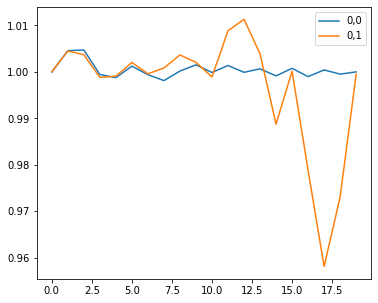

In [17]:
%matplotlib inline

binner = ClBinner(lmin=100,lmax=6000,nbin=20)

fig,ax = plt.subplots(figsize=(6,5))

cl_ilc_0_0 = curvedsky.alm2cl(total_alms["hilc"][0], total_alms["hilc"][0])
cl_ilc_0_1 = curvedsky.alm2cl(total_alms["hilc"][0], total_alms["hilc"][1])

cl_ilc_0_0_input = data_cl_signal_dict['hilc','hilc'][100:]+data_cl_noise_dict['hilc','hilc'][100:]
cl_ilc_0_1_input = data_cl_signal_dict['hilc','hilc'][100:]

ax.plot(binner(cl_ilc_0_0[100:])/binner(cl_ilc_0_0_input),label="0,0")
ax.plot(binner(cl_ilc_0_1[100:])/binner(cl_ilc_0_1_input),label="0,1")
#axs[0].set_yscale("log")
ax.legend()
#ax.plot(cl_ilc_signal[100:], label="signal")
#ax.plot(cl_ilc_0_0_signal[100:],label="ilc sim signal")
#ax.plot(cl_tszandcibd_0_0_signal[100:],label="tszandcibd sim signal")


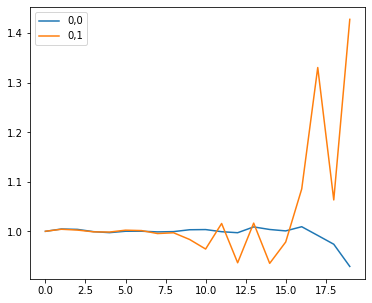

In [18]:
%matplotlib inline

binner = ClBinner(lmin=100,lmax=6000,nbin=20)

fig,ax = plt.subplots(figsize=(6,5))

cl_ilc_tszandcibd_0_0 = curvedsky.alm2cl(total_alms["hilc-tszandcibd"][0], total_alms["hilc"][0])
cl_ilc_tszandcibd_0_1 = curvedsky.alm2cl(total_alms["hilc-tszandcibd"][0], total_alms["hilc"][1])

cl_ilc_tszandcibd_0_0_input = data_cl_signal_dict['hilc','hilc-tszandcibd'][100:]+data_cl_noise_dict['hilc','hilc-tszandcibd'][100:]
cl_ilc_tszandcibd_0_1_input = data_cl_signal_dict['hilc','hilc-tszandcibd'][100:]

ax.plot(binner(cl_ilc_tszandcibd_0_0[100:])/binner(cl_ilc_tszandcibd_0_0_input),label="0,0")
ax.plot(binner(cl_ilc_tszandcibd_0_1[100:])/binner(cl_ilc_tszandcibd_0_1_input),label="0,1")
ax.legend()

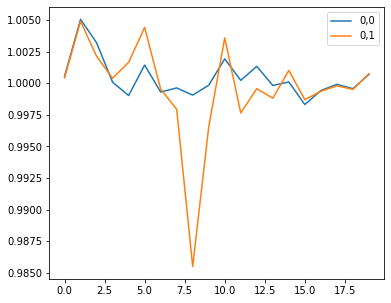

In [22]:
%matplotlib inline

binner = ClBinner(lmin=100,lmax=6000,nbin=20)

fig,ax = plt.subplots(figsize=(6,5))

cl_tszandcibd_0_0 = curvedsky.alm2cl(total_alms["hilc-tszandcibd"][0], total_alms["hilc-tszandcibd"][0])
cl_tszandcibd_0_1 = curvedsky.alm2cl(total_alms["hilc-tszandcibd"][0], total_alms["hilc-tszandcibd"][1])

cl_tszandcibd_0_0_input = data_cl_signal_dict['hilc-tszandcibd','hilc-tszandcibd'][100:]+data_cl_noise_dict['hilc-tszandcibd','hilc-tszandcibd'][100:]
cl_tszandcibd_0_1_input = data_cl_signal_dict['hilc-tszandcibd','hilc-tszandcibd'][100:]

ax.plot(binner(cl_tszandcibd_0_0[100:])/binner(cl_tszandcibd_0_0_input),label="0,0")
ax.plot(binner(cl_tszandcibd_0_1[100:])/binner(cl_tszandcibd_0_1_input),label="0,1")
ax.legend()

(0.5, 1.5)

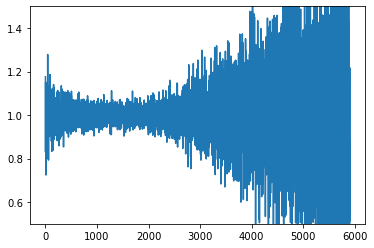

In [20]:
%matplotlib inline

fig,ax = plt.subplots()
ax.plot(cl_ilc_0_1[100:]/data_cl_signal_dict['hilc','hilc'][100:])
ax.set_ylim([0.5,1.5])

In [8]:
total_alms_2,signal_alms_2,noise_alms_2 = get_sims_from_cls(data_cl_signal_dict, data_cl_noise_dict, 2345, 2346, mlmax=6000)

getting sims for channels: ['hilc-tszandcibd', 'hilc']
getting signal cov
signal_cov.shape: (2, 2, 6001)
generating signal alms
Getting noise alms


In [14]:
cl_90_0_0p = curvedsky.alm2cl(total_alms["90"][0], total_alms_2["90"][0])
cl_90_0_1p = curvedsky.alm2cl(total_alms["90"][0], total_alms_2["90"][1])

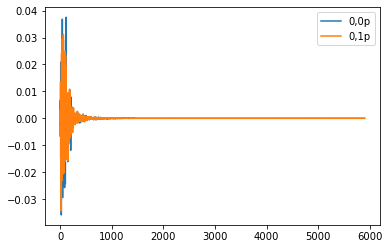

In [16]:
%matplotlib inline

fig,ax = plt.subplots()
ax.plot(cl_90_0_0p[100:],label="0,0p")
ax.plot(cl_90_0_1p[100:],label="0,1p")
ax.legend()